# Importing various packages

In [3]:
import numpy as np

import pandas as pd 


import json
# !conda install -c conda-forge  geopy  geocoder beautifulsoup4  -y # this is for installs
from geopy.geocoders import Nominatim
import geocoder

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


# Web Scraping
This is spread across two pages. So, we are scraping two pages and getting the list.

Finally creating list based on the scraped results.

In [9]:
page1 = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India").text
page2 = requests.get("https://en.wikipedia.org/w/index.php?title=Category:Neighbourhoods_in_Hyderabad,_India&pagefrom=Srinagar+colony#mw-pages").text
soup1 = BeautifulSoup(page1, 'html.parser')
soup2 = BeautifulSoup(page2, 'html.parser')
neighborhoodList = []
itemset1 = soup1.find_all("div", class_="mw-category")[0].findAll("li")
itemset2 = soup2.find_all("div", class_="mw-category")[0].findAll("li")

for row in itemset1:
    neighborhoodList.append(row.text)
for row in itemset2:
    neighborhoodList.append(row.text)

hyd = pd.DataFrame({"Neighborhood": neighborhoodList})

hyd

,Neighborhood
0,A. S. Rao Nagar
1,A.C. Guards
2,Abhyudaya Nagar
3,Abids
4,Adikmet
...,...
215,Warsiguda
216,Yakutpura
217,Yapral
218,Yellareddyguda


In [5]:
hyd.shape

(220, 1)

# Getting Locations of neighborhood with Geocoder package
Now it is time to get the locations of all the neighborhoods. Geocoder package will help us to make this quick.

This is a function which takes a list and returns a list of latitudes and longitudes

In [6]:

# define a function to get coordinates
def get_latlng(neighborhoods):
    lat = []
    long = []
    for neighborhood in neighborhoods:
        # initialize your variable to None
        lat_lng_coords = None
        # loop until you get the coordinates
        while(lat_lng_coords is None):
            g = geocoder.arcgis('{}, Hyderabad, India'.format(neighborhood))
            lat_lng_coords = g.latlng
        lat.append(lat_lng_coords[0])
        long.append(lat_lng_coords[1]) 

    return lat, long

This cell will call the above function and store the lats and longs

In [7]:
lat, long = get_latlng(hyd["Neighborhood"].tolist())
print(lat[0:5], long[0:5])

[17.411200000000065, 17.392977027745946, 17.337650000000053, 17.389800000000037, 17.410610000000077] [78.50824000000006, 78.45686724051741, 78.56414000000007, 78.47658000000007, 78.51513000000006]


# This cell will add the columns to the dataframe

In [10]:
hyd['latitude'] = lat
hyd['longitude'] = long
hyd

,Neighborhood,latitude,longitude
0,A. S. Rao Nagar,17.411200,78.508240
1,A.C. Guards,17.392977,78.456867
2,Abhyudaya Nagar,17.337650,78.564140
3,Abids,17.389800,78.476580
4,Adikmet,17.410610,78.515130
...,...,...,...
215,Warsiguda,17.419350,78.518870
216,Yakutpura,17.360920,78.490830
217,Yapral,17.514290,78.523650
218,Yellareddyguda,17.433920,78.434680


IN order to avoid preprocession next time I am saving this

In [12]:
hyd.to_csv('hyd.csv', index=False)

# Validating the latitudes and longitudes given by the geocoder package using folium

In [11]:
# get the coordinates of Kuala Lumpur
address = 'Hyderabad, India'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad, India {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad, India 17.38878595, 78.46106473453146.


# Initializing a folium map with all the neighborhoods

In [9]:
map_hyd = folium.Map(location=[17.38878595, 78.46106473453146], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(hyd['latitude'], hyd['longitude'], hyd['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_hyd)  
    
map_hyd

In [10]:
map_hyd.save('map_hyd.html')

# Giving the credentials for Foursquare API

In [13]:
CLIENT_ID = 'intensionally removed' # your Foursquare ID
CLIENT_SECRET = 'intensionally removed' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KNTVM1TSE5FXGSP5GQ2PPWY13UR3YPEBFRTKDUOHZRQKAOK1
CLIENT_SECRET:DBM03ZSEIDKDJ22LVKOZKSYBQW1CIFWDLBDTI4HJYG0WFIWY


In [50]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius
categoryId = '4bf58dd8d48988d104941735'
latitude = 17.411200000000065
longitude = 78.50824000000006
url = 'https://api.foursquare.com/v2/venues/search?&ll={},{}&categoryId={}&client_id={}&client_secret={}&v={}&radius={}'.format(
    latitude,
    longitude,
    categoryId,
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION,
    radius)
url 

'https://api.foursquare.com/v2/venues/search?&ll=17.411200000000065,78.50824000000006&categoryId=4bf58dd8d48988d104941735&client_id=KNTVM1TSE5FXGSP5GQ2PPWY13UR3YPEBFRTKDUOHZRQKAOK1&client_secret=DBM03ZSEIDKDJ22LVKOZKSYBQW1CIFWDLBDTI4HJYG0WFIWY&v=20180605&radius=1000'

In [51]:
results = requests.get(url).json()
# results

In [52]:
len(results['response']['venues'])

13

# Creating a url and accessing the foursquare API. To get the hospitals based on the category search

In [14]:
def getHospCount(lat, long):
    radius = 1000 # define radius
    categoryId = '4bf58dd8d48988d104941735'
    latitude = lat
    longitude = long
    url = 'https://api.foursquare.com/v2/venues/search?&ll={},{}&categoryId={}&client_id={}&client_secret={}&v={}&radius={}'.format(
        latitude,
        longitude,
        categoryId,
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION,
        radius)
    results = requests.get(url).json()
    return len(results['response']['venues'])

In [15]:
hospitals = []
for lat, long in zip(hyd['latitude'], hyd['longitude']):
    hospitals.append(getHospCount(lat, long))
# hospitals

# Adding the hospitals count to the dataframe "Hospitals"

In [16]:
hyd['Hospitals'] = hospitals
hyd.to_csv('hyd_hosp.csv', index=False)

In [4]:
hyd = pd.read_csv('hyd_hosp.csv')
hyd

,Neighborhood,latitude,longitude,Hospitals
0,A. S. Rao Nagar,17.411200,78.508240,13
1,A.C. Guards,17.392977,78.456867,24
2,Abhyudaya Nagar,17.337650,78.564140,7
3,Abids,17.389800,78.476580,26
4,Adikmet,17.410610,78.515130,11
...,...,...,...,...
215,Warsiguda,17.419350,78.518870,2
216,Yakutpura,17.360920,78.490830,6
217,Yapral,17.514290,78.523650,2
218,Yellareddyguda,17.433920,78.434680,27


# Finding the best K value and the result is "3"

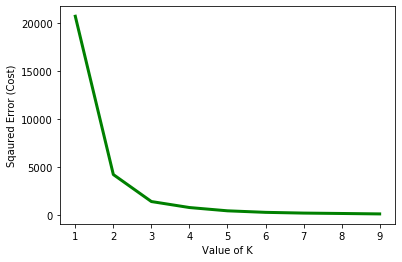

In [20]:
import matplotlib.pyplot as plt
cost =[] 
for i in range(1, 10): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(hyd[['Hospitals']]) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 10), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()


# Training the Kmeans algorithm with 3 clusters

In [5]:
# set number of clusters
kclusters = 3



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hyd[['Hospitals']])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 1, 0, 2, 0, 2, 1, 1, 1], dtype=int32)

# Adding labels of the kmeans to the dataframe to a column named "Labels"

In [6]:
hyd['Labels'] = kmeans.labels_
hyd.to_csv('hyd_hosp_labeled.csv', index=False)
hyd

,Neighborhood,latitude,longitude,Hospitals,Labels
0,A. S. Rao Nagar,17.411200,78.508240,13,2
1,A.C. Guards,17.392977,78.456867,24,0
2,Abhyudaya Nagar,17.337650,78.564140,7,1
3,Abids,17.389800,78.476580,26,0
4,Adikmet,17.410610,78.515130,11,2
...,...,...,...,...,...
215,Warsiguda,17.419350,78.518870,2,1
216,Yakutpura,17.360920,78.490830,6,1
217,Yapral,17.514290,78.523650,2,1
218,Yellareddyguda,17.433920,78.434680,27,0


# Let's see the mean no of hospitals in each cluster

In [23]:
hyd.groupby(['Labels']).mean()

,latitude,longitude,Hospitals
Labels,,,
0,17.411407,78.474197,25.298246
1,17.416220,78.472323,2.745283
2,17.405331,78.479936,13.894737


# Group 0 - 25 hospitals per Km
# Group 1 - 2 hospitals per km
# Group 2 - 13 hospitals per km

# Create a map with the specified clusters - see report for MAP

In [7]:
latitude = 17.38878595
longitude = 78.46106473453146
clustered_map = folium.Map(location=[latitude, longitude], zoom_start=11)
kcluters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyd['latitude'], hyd['longitude'], hyd['Neighborhood'], hyd['Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clustered_map)
       
clustered_map

In [8]:
clustered_map.save('clustered_map.html')

# Observations 
This is very obvious that the high density group i.e., group 0 with 25 hospitals/Km is situated at the center of the city
Then we got the group 2 with an average count of 13/km. That is surrounding the group 0. This shows that it is an extended city.
Finally group 1 with 3 hospitals/km. These are in the city suburbs.

# Based on the above analysis it is clear that if a person starts a hospital in suburbs he is going to succeed. Along with that, many people  will get a chance to get the better health care

# The End 